## Part 1. Data Processing

In [1]:
import math

import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db
import sqlite3
import numpy as np
import matplotlib as mpl

In [2]:
TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

### Calculating Distance

In [3]:
from math import radians, cos, sin, asin, sqrt, atan, atan2
# longitude and latitude of pickup and dropoff locations
def calculate_distance(Pickup_Longitude, Pickup_Latitude, Dropoff_Longitude, Dropoff_Latitude):
    # transfer numbers to radius
    Pickup_Longitude = radians(Pickup_Longitude)
    Pickup_Latitude = radians(Pickup_Latitude)
    Dropoff_Longitude = radians(Dropoff_Longitude)
    Dropoff_Latitude = radians(Dropoff_Latitude)
    # the formulas of calculate_distance
    dlon = Dropoff_Longitude - Pickup_Longitude
    dlat = Dropoff_Latitude - Pickup_Latitude
    a = sin(dlat/2)**2 + cos(Pickup_Latitude) * cos(Dropoff_Latitude) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    r = 6371 # The Average Radius of Earth
    Distance = c*r
    return Distance

### Processing Uber Data
#### Import Uber Data

In [115]:
df_Uber = pd.read_csv(r'C:\Users\siqie\Desktop\uber_rides_sample.csv') # Load the data for Uber Rides

#### Clean Uber data by deleting unused columns

In [116]:
# Delete the unused columns from Uber data
del df_Uber["Unnamed: 0"]   
del df_Uber["key"]

#### Normalize the column names

In [117]:
df_Uber.rename(columns={
                        'fare_amount':'Fare_Amount', 
                        'pickup_datetime':'Pickup_DateTime', 
                        'pickup_longitude':'Pickup_Longitude', 
                        'pickup_latitude':'Pickup_Latitude',
                        'dropoff_longitude':'Dropoff_Longitude',
                        'dropoff_latitude':'Dropoff_Latitude',
                        'passenger_count':'Passenger_Count'
                       }, inplace = True)

#### Only include rides that's in our circled area

In [118]:
# Circle the areas that we are considering: ((40.560445, -74.242330), (40.908524, -73.717047))
df_Uber=df_Uber[df_Uber["Pickup_Longitude"] <= -73.717047]  
df_Uber=df_Uber[df_Uber["Pickup_Longitude"] >= -74.242330]
df_Uber=df_Uber[df_Uber["Pickup_Latitude"] >= 40.560445]
df_Uber=df_Uber[df_Uber["Pickup_Latitude"] <= 40.908524]
df_Uber=df_Uber[df_Uber["Dropoff_Longitude"] <= -73.717047]
df_Uber=df_Uber[df_Uber["Dropoff_Longitude"] >= -74.242330]
df_Uber=df_Uber[df_Uber["Dropoff_Latitude"] >= 40.560445]
df_Uber=df_Uber[df_Uber["Dropoff_Latitude"] <= 40.908524]
# Remove all the rows that has cordinates with 0, which are considered as invalid value. 
df_Uber=df_Uber[df_Uber.Pickup_Longitude != 0]
df_Uber=df_Uber[df_Uber.Pickup_Latitude != 0]
df_Uber=df_Uber[df_Uber.Dropoff_Longitude != 0]
df_Uber=df_Uber[df_Uber.Dropoff_Latitude != 0]

#### Seperate Date and Time

In [120]:
## Seperate Date and Time for Taxi data, add Day of Week
df_Uber['Pickup_DateTime'] = pd.to_datetime(df_Uber['Pickup_DateTime'])
df_Uber['Pickup_Date'] = [d.date() for d in df_Uber['Pickup_DateTime']]
df_Uber['Pickup_Time'] = [d.time() for d in df_Uber['Pickup_DateTime']]

df_Uber['DayofWeek'] = df_Uber['Pickup_DateTime'].dt.day_name()

## Move the Date, Time and Day of Week columns to front
Pickup_Date1 = df_Uber['Pickup_Date']
df_Uber.drop(labels=['Pickup_Date'], axis=1, inplace=True)
df_Uber.insert(2, "Pickup_Date", Pickup_Date1)

Pickup_Time1 = df_Uber['Pickup_Time']
df_Uber.drop(labels=['Pickup_Time'], axis=1, inplace=True)
df_Uber.insert(3, "Pickup_Time", Pickup_Time1)


DayofWeek1 = df_Uber['DayofWeek']
df_Uber.drop(labels=['DayofWeek'], axis=1, inplace=True)
df_Uber.insert(4, "DayofWeek", DayofWeek1)

## Split Year, Month, Date, and hour into seperate columns
df_Uber['Year'] = df_Uber['Pickup_DateTime'].dt.year
df_Uber['Month'] = df_Uber['Pickup_DateTime'].dt.month
df_Uber['Day'] = df_Uber['Pickup_DateTime'].dt.day
df_Uber['Hour'] = df_Uber['Pickup_DateTime'].dt.hour


#### Insert a column for travel distance

In [121]:
# This formula takes about 8 minutes to generate the Distance column in df_Uber dataframe
# Since the data frames will be exported to cvs files, don't run this if not necessary!
df_Uber['Distance'] = [calculate_distance(**df_Uber[['Pickup_Latitude', 'Pickup_Longitude', 'Dropoff_Latitude', 'Dropoff_Longitude']].iloc[i].to_dict()) for i in range(df_Uber.shape[0])]
df_Uber

,Fare_Amount,Pickup_DateTime,Pickup_Date,Pickup_Time,DayofWeek,Pickup_Longitude,Pickup_Latitude,Dropoff_Longitude,Dropoff_Latitude,Passenger_Count,Year,Month,Day,Hour,Distance
0,7.50,2015-05-07 19:52:06,2015-05-07,19:52:06,Thursday,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,1.683323
1,7.70,2009-07-17 20:04:56,2009-07-17,20:04:56,Friday,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,2.457590
2,12.90,2009-08-24 21:45:00,2009-08-24,21:45:00,Monday,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,5.036377
3,5.30,2009-06-26 08:22:21,2009-06-26,08:22:21,Friday,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,1.661683
4,16.00,2014-08-28 17:47:00,2014-08-28,17:47:00,Thursday,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,4.475450
5,4.90,2011-02-12 02:27:09,2011-02-12,02:27:09,Saturday,-73.969019,40.755910,-73.969019,40.755910,1,2011,2,12,2,0.000000
6,24.50,2014-10-12 07:04:00,2014-10-12,07:04:00,Sunday,-73.961447,40.693965,-73.871195,40.774297,5,2014,10,12,7,11.731015
8,9.70,2012-02-17 09:32:00,2012-02-17,09:32:00,Friday,-73.975187,40.745767,-74.002720,40.743537,1,2012,2,17,9,2.332711
9,12.50,2012-03-29 19:06:00,2012-03-29,19:06:00,Thursday,-74.001065,40.741787,-73.963040,40.775012,1,2012,3,29,19,4.889417
10,6.50,2015-05-22 17:32:27,2015-05-22,17:32:27,Friday,-73.974388,40.746952,-73.988586,40.729805,1,2015,5,22,17,2.250858


#### Export the data as csv

In [122]:
df_Uber.to_csv(r'D:\IEOR4501Project\final_uber_data.csv', index = None, header=True)

### Processing Weather Data
#### Import weather data

In [129]:
# Loading all weather data from 2009 to 2015
df_Weather_2009 = pd.read_csv(r'C:\Users\siqie\Desktop\2009_weather.csv')
df_Weather_2010 = pd.read_csv(r'C:\Users\siqie\Desktop\2010_weather.csv')
df_Weather_2011 = pd.read_csv(r'C:\Users\siqie\Desktop\2011_weather.csv')
df_Weather_2012 = pd.read_csv(r'C:\Users\siqie\Desktop\2012_weather.csv')
df_Weather_2013 = pd.read_csv(r'C:\Users\siqie\Desktop\2013_weather.csv')
df_Weather_2014 = pd.read_csv(r'C:\Users\siqie\Desktop\2014_weather.csv')
df_Weather_2015 = pd.read_csv(r'C:\Users\siqie\Desktop\2015_weather.csv')

#### Remove unnecessary columns for each dataset


In [130]:
# Since there are too many columns we want to delete, we used "column number" method to clean the data
df_Weather_2009 = df_Weather_2009.drop(df_Weather_2009.columns[[0,2,3,4,5,7,8,12,13,14,15,16,17,18,19,20,21,28,29,30,31,33,34,35,41,42,43,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122]], axis=1)
df_Weather_2010 = df_Weather_2010.drop(df_Weather_2010.columns[[0,2,3,4,5,7,8,12,13,14,15,16,17,18,19,20,21,28,29,30,31,33,34,35,41,42,43,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122]], axis=1)
df_Weather_2011 = df_Weather_2011.drop(df_Weather_2011.columns[[0,2,3,4,5,7,8,12,13,14,15,16,17,18,19,20,21,28,29,30,31,33,34,35,41,42,43,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122]], axis=1)
df_Weather_2012 = df_Weather_2012.drop(df_Weather_2012.columns[[0,2,3,4,5,7,8,12,13,14,15,16,17,18,19,20,21,28,29,30,31,33,34,35,41,42,43,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122]], axis=1)
df_Weather_2013 = df_Weather_2013.drop(df_Weather_2013.columns[[0,2,3,4,5,7,8,12,13,14,15,16,17,18,19,20,21,28,29,30,31,33,34,35,41,42,43,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122]], axis=1)
df_Weather_2014 = df_Weather_2014.drop(df_Weather_2014.columns[[0,2,3,4,5,7,8,12,13,14,15,16,17,18,19,20,21,28,29,30,31,33,34,35,41,42,43,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122]], axis=1)
df_Weather_2015 = df_Weather_2015.drop(df_Weather_2015.columns[[0,2,3,4,5,7,8,12,13,14,15,16,17,18,19,20,21,28,29,30,31,33,34,35,41,42,43,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122]], axis=1)



#### Put together hourly weather data

In [131]:
# Since we will only focus on the weather from 2012 to 2014, then we only clean up what we need.
## All the hourly data has REPORT_TYPE: FM-15, so we only select FM-15
df_Weather_2012_hourly = df_Weather_2012[df_Weather_2012['REPORT_TYPE'].str.contains('FM-15')]
df_Weather_2013_hourly = df_Weather_2013[df_Weather_2013['REPORT_TYPE'].str.contains('FM-15')]
df_Weather_2014_hourly = df_Weather_2014[df_Weather_2014['REPORT_TYPE'].str.contains('FM-15')]

## Put 3 hourly data into one hourly weather data
frames1 = [df_Weather_2012_hourly, df_Weather_2013_hourly, df_Weather_2014_hourly]
df_Weather_hourly = pd.concat(frames1)



#### Clean up hourly weather data

In [132]:
# Delete unnecessary columns from the table (Most of the daily data). 
df_Weather_hourly = df_Weather_hourly.drop(df_Weather_hourly.columns[[9,10,11,12,13,14,15,16,17]], axis=1)


In [140]:
# Change Column Names
df_Weather_hourly.rename(columns={
                        'DATE':'DateTime'
                       }, inplace = True)

## Seperate Date and Time for Taxi data, add Day of Week
df_Weather_hourly['DateTime'] = pd.to_datetime(df_Weather_hourly['DateTime'])
df_Weather_hourly['Date'] = [d.date() for d in df_Weather_hourly['DateTime']]
df_Weather_hourly['Time'] = [d.time() for d in df_Weather_hourly['DateTime']]

df_Weather_hourly['DayofWeek'] = df_Weather_hourly['DateTime'].dt.day_name()

## Move the Date, Time and Day of Week columns to front
W_hourly_Date = df_Weather_hourly['Date']
df_Weather_hourly.drop(labels=['Date'], axis=1, inplace=True)
df_Weather_hourly.insert(1, "Date", W_hourly_Date)

W_hourly_Time = df_Weather_hourly['Time']
df_Weather_hourly.drop(labels=['Time'], axis=1, inplace=True)
df_Weather_hourly.insert(2, "Time", W_hourly_Time)


DayofWeek_WH = df_Weather_hourly['DayofWeek']
df_Weather_hourly.drop(labels=['DayofWeek'], axis=1, inplace=True)
df_Weather_hourly.insert(3, "DayofWeek", DayofWeek_WH)

## Split Year, Month, Date, and hour into seperate columns
df_Weather_hourly['Year'] = df_Weather_hourly['DateTime'].dt.year
df_Weather_hourly['Month'] = df_Weather_hourly['DateTime'].dt.month
df_Weather_hourly['Day'] = df_Weather_hourly['DateTime'].dt.day
df_Weather_hourly['Hour'] = df_Weather_hourly['DateTime'].dt.hour

# Replace T in Precipitation column with 0 since T means trace amount and we would like to have it as an integer
df_Weather_hourly['HourlyPrecipitation'].replace({"T": 0}, inplace=True)


#### Put together daily weather data

In [141]:
# For daily data we will also focus on 2012 to 2014
## All the daily data has REPORT_TYPE: SOD, so we only select SOD data.
df_Weather_2012_daily = df_Weather_2012[df_Weather_2012['REPORT_TYPE'].str.contains('SOD')]
df_Weather_2013_daily = df_Weather_2013[df_Weather_2013['REPORT_TYPE'].str.contains('SOD')]
df_Weather_2014_daily = df_Weather_2014[df_Weather_2014['REPORT_TYPE'].str.contains('SOD')]

## Put 3 daily data into one hourly weather data
frames2 = [df_Weather_2012_daily, df_Weather_2013_daily, df_Weather_2014_daily]
df_Weather_daily = pd.concat(frames2)

#### Clean up daily weather data

In [142]:
# Delete unnecessary columns (hourly data)
df_Weather_daily = df_Weather_daily.drop(df_Weather_daily.columns[[2,3,4,5,6]], axis=1)
df_Weather_daily.rename(columns={"DailySustainedWindSpeed":"SustainedWindSpeed"}, inplace = True)


In [143]:
# Change Column Names
df_Weather_daily.rename(columns={
                        'DATE':'DateTime'
                       }, inplace = True)

## Seperate Date and time, add Day of Week
df_Weather_daily['DateTime'] = pd.to_datetime(df_Weather_daily['DateTime'])
df_Weather_daily['Date'] = [d.date() for d in df_Weather_daily['DateTime']]

df_Weather_daily['DayofWeek'] = df_Weather_daily['DateTime'].dt.day_name()

## Move the Date and Day of Week columns to front
W_daily_Date = df_Weather_daily['Date']
df_Weather_daily.drop(labels=['Date'], axis=1, inplace=True)
df_Weather_daily.insert(1, "Date", W_daily_Date)


DayofWeek_WD = df_Weather_daily['DayofWeek']
df_Weather_daily.drop(labels=['DayofWeek'], axis=1, inplace=True)
df_Weather_daily.insert(3, "DayofWeek", DayofWeek_WD)

## Split Year, Month, Date into seperate columns
df_Weather_daily['Year'] = df_Weather_daily['DateTime'].dt.year
df_Weather_daily['Month'] = df_Weather_daily['DateTime'].dt.month
df_Weather_daily['Day'] = df_Weather_daily['DateTime'].dt.day

# Replace T in Precipitation column with 0 since T means trace amount and we would like to have it as an integer
df_Weather_daily['DailyPrecipitation'].replace({"T": 0}, inplace=True)

df_Weather_daily

,DateTime,Date,REPORT_TYPE,DayofWeek,Sunrise,Sunset,DailyAverageDewPointTemperature,DailyAverageDryBulbTemperature,DailyAverageWindSpeed,DailyMaximumDryBulbTemperature,DailyMinimumDryBulbTemperature,DailyPeakWindDirection,DailyPeakWindSpeed,DailyPrecipitation,SustainedWindSpeed,Year,Month,Day
30,2012-01-01 23:59:00,2012-01-01,SOD,Sunday,720.0,1639.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,1,1
244,2012-01-10 23:59:00,2012-01-10,SOD,Tuesday,720.0,1648.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,1,10
274,2012-01-11 23:59:00,2012-01-11,SOD,Wednesday,720.0,1649.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,1,11
326,2012-01-12 23:59:00,2012-01-12,SOD,Thursday,719.0,1650.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,1,12
362,2012-01-13 23:59:00,2012-01-13,SOD,Friday,719.0,1651.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,1,13
435,2012-01-16 23:59:00,2012-01-16,SOD,Monday,718.0,1654.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,1,16
472,2012-01-17 23:59:00,2012-01-17,SOD,Tuesday,717.0,1655.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,1,17
590,2012-01-21 23:59:00,2012-01-21,SOD,Saturday,715.0,1700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,1,21
669,2012-01-23 23:59:00,2012-01-23,SOD,Monday,714.0,1702.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,1,23
754,2012-01-26 23:59:00,2012-01-26,SOD,Thursday,712.0,1706.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,1,26


#### Generate values for hourly sustained wind speed

In [144]:
df_Weather_hourly = pd.merge(df_Weather_hourly, df_Weather_daily.loc[:,['Date', 'SustainedWindSpeed']], how='left', on='Date')
df_Weather_hourly

,DateTime,Date,Time,DayofWeek,REPORT_TYPE,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyWindGustSpeed,HourlyWindSpeed,Sunrise,Sunset,Year,Month,Day,Hour,SustainedWindSpeed
0,2012-01-01 06:00:00,2012-01-01,06:00:00,Sunday,FM-15,36,37,NaN,NaN,8.0,NaN,NaN,2012,1,1,6,NaN
1,2012-01-01 08:00:00,2012-01-01,08:00:00,Sunday,FM-15,36,37,NaN,NaN,0.0,NaN,NaN,2012,1,1,8,NaN
2,2012-01-12 08:00:00,2012-01-12,08:00:00,Thursday,FM-15,43,43,0.03,NaN,0.0,NaN,NaN,2012,1,12,8,NaN
3,2012-01-17 15:00:00,2012-01-17,15:00:00,Tuesday,FM-15,41,43,0.01,18.0,10.0,NaN,NaN,2012,1,17,15,NaN
4,2012-01-27 01:00:00,2012-01-27,01:00:00,Friday,FM-15,39,41,NaN,NaN,3.0,NaN,NaN,2012,1,27,1,NaN
5,2012-01-27 03:00:00,2012-01-27,03:00:00,Friday,FM-15,43,43,NaN,NaN,5.0,NaN,NaN,2012,1,27,3,NaN
6,2012-01-27 07:00:00,2012-01-27,07:00:00,Friday,FM-15,48,48,0,NaN,7.0,NaN,NaN,2012,1,27,7,NaN
7,2012-01-27 11:00:00,2012-01-27,11:00:00,Friday,FM-15,55,55,0.01,NaN,3.0,NaN,NaN,2012,1,27,11,NaN
8,2012-02-02 00:51:00,2012-02-02,00:51:00,Thursday,FM-15,34,48,NaN,NaN,5.0,NaN,NaN,2012,2,2,0,NaN
9,2012-02-02 01:51:00,2012-02-02,01:51:00,Thursday,FM-15,32,46,NaN,NaN,3.0,NaN,NaN,2012,2,2,1,NaN


#### Export Weather data into csv files

In [145]:
df_Weather_hourly.to_csv(r'D:\IEOR4501Project\Weather_hourly_Data.csv', index = None, header=True)
df_Weather_daily.to_csv(r'D:\IEOR4501Project\Weather_daily_Data.csv', index = None, header=True)

### Yellow Taxi Data

In [2]:
import math

import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db

import re

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [4]:
# Get UBER data and count the number of rows in each month

def load_and_clean_uber_data(csv_file):
    
    df = pd.read_csv (csv_file)
    
    del df["Unnamed: 0"]
    del df["key"]
    df = df[df["pickup_longitude"] <= -73.717047]
    df = df[df["pickup_longitude"] >= -74.242330]
    df = df[df["dropoff_longitude"] <= -73.717047]
    df = df[df["dropoff_longitude"] >= -74.242330]
    df = df[df["pickup_latitude"] <= 40.908524]
    df = df[df["pickup_latitude"] >= 40.560445]
    df = df[df["dropoff_latitude"] <= 40.908524]
    df = df[df["dropoff_latitude"] >= 40.560445]
    
    # df.to_csv('uber_data.csv')
    return df
    
    # raise NotImplemented()
    
def get_uber_data():
    
    uber_dataframe = load_and_clean_uber_data(r'/Users/sandyfan/Desktop/project/uber_rides_sample.csv')
    # uber_dataframe = load_and_clean_uber_data(r'/content/gdrive/My Drive//uber_rides_sample.csv')
    
    # add_distance_column(uber_dataframe)
    
    return uber_dataframe

In [5]:
def find_taxi_csv_urls():
    
    #content = requests.get('https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page')
    content = requests.get(TAXI_URL)
        
    soup = bs4.BeautifulSoup(content.text, 'html.parser')
    
    links = []
    for x in [a['href'] for a in soup.find_all('a')]:
        string = x
        pattern = re.compile(r"https://s3.amazonaws.com/nyc-tlc/trip\+\bdata/yell.*[\W_]csv")
        match = pattern.findall(string)
        if match != []:
            a = match[0]
            links.append(a)
            
    yellow_taxi = links[54:]   # get the links of all years that we need 
    
    
    return yellow_taxi
    
    # raise NotImplemented()

In [6]:
def get_month_taxi_data(url,year,month):
    
    taxi_link = pd.read_csv(url)
    #taxi_link  = pd.read_csv(url,on_bad_lines='skip')
    
    # removing trips that start and/or end outside
    #taxi_link = taxi_link[taxi_link["pickup_longitude"] <= -73.717047]
    #taxi_link = taxi_link[taxi_link["pickup_longitude"] >= -74.242330]
    #taxi_link = taxi_link[taxi_link["dropoff_longitude"] <= -73.717047]
    #taxi_link = taxi_link[taxi_link["dropoff_longitude"] >= -74.242330]
    #taxi_link = taxi_link[taxi_link["pickup_latitude"] <= 40.908524]
    #taxi_link = taxi_link[taxi_link["pickup_latitude"] >= 40.560445]
    #taxi_link = taxi_link[taxi_link["dropoff_latitude"] <= 40.908524]
    #taxi_link = taxi_link[taxi_link["dropoff_latitude"] >= 40.560445]

    # FOR 2014 dataset: different format of columns' names
    # print(taxi_link_2014.columns.tolist()) -- check columns' names
    taxi_link = taxi_link[taxi_link[" pickup_longitude"] <= -73.717047]
    taxi_link = taxi_link[taxi_link[" pickup_longitude"] >= -74.242330]
    taxi_link = taxi_link[taxi_link[" dropoff_longitude"] <= -73.717047]
    taxi_link = taxi_link[taxi_link[" dropoff_longitude"] >= -74.242330]
    taxi_link = taxi_link[taxi_link[" pickup_latitude"] <= 40.908524]
    taxi_link = taxi_link[taxi_link[" pickup_latitude"] >= 40.560445]
    taxi_link = taxi_link[taxi_link[" dropoff_latitude"] <= 40.908524]
    taxi_link = taxi_link[taxi_link[" dropoff_latitude"] >= 40.560445]

    #taxi_link = taxi_link[taxi_link["Start_Lon"] <= -73.717047]
    #taxi_link = taxi_link[taxi_link["Start_Lon"] >= -74.242330]
    #taxi_link = taxi_link[taxi_link["End_Lon"] <= -73.717047]
    #taxi_link = taxi_link[taxi_link["End_Lon"] >= -74.242330]
    #taxi_link = taxi_link[taxi_link["Start_Lat"] <= 40.908524]
    #taxi_link = taxi_link[taxi_link["Start_Lat"] >= 40.560445]
    #taxi_link = taxi_link[taxi_link["End_Lat"] <= 40.908524]
    #taxi_link = taxi_link[taxi_link["End_Lat"] >= 40.560445]
    
    sample_data = taxi_link.sample(month_name_values[year][month])
    
    return sample_data

### Get & Clean Sample Data
### Too slow to run -- run in colab -- DO NOT RUN THIS PART 

In [ ]:
def get_and_clean_taxi_data_2015():      
    
    taxi_dataframes_2015 = []
    
    all_csv_urls = find_taxi_csv_urls()
    
    for i in range(6):    # set as 6 b/c there are only first six months uber data in 2015

        dataframe = get_month_taxi_data(all_csv_urls[i],2015,i+1)
        
        # add_distance_column(dataframe)
        
        taxi_dataframes_2015.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data_2015 = pd.concat(taxi_dataframes_2015)
    return taxi_data_2015

In [ ]:
yellow_taxi_2015 = get_and_clean_taxi_data_2015()
yellow_taxi_2015.to_csv('yellow_2015.csv')

In [ ]:
def get_and_clean_taxi_data_2014():      
    
    taxi_dataframes_2014 = []
    
    all_csv_urls = find_taxi_csv_urls()
    
    for i in range(12,24):

        dataframe = get_month_taxi_data(all_csv_urls[i],2014,i-11)
        
        # add_distance_column(dataframe)
        
        taxi_dataframes_2014.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data_2014 = pd.concat(taxi_dataframes_2014)
    return taxi_data_2014

In [ ]:
yellow_taxi_2014 = get_and_clean_taxi_data_2014()
yellow_taxi_2014.to_csv('yellow_2014.csv')

In [ ]:
def get_and_clean_taxi_data_2013():      
    
    taxi_dataframes_2013 = []
    
    all_csv_urls = find_taxi_csv_urls()
    
    for i in range(24,36):

        dataframe = get_month_taxi_data(all_csv_urls[i],2013,i-23)
        
        # add_distance_column(dataframe)
        
        taxi_dataframes_2013.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data_2013 = pd.concat(taxi_dataframes_2013)
    return taxi_data_2013

In [ ]:
yellow_taxi_2013 = get_and_clean_taxi_data_2013()
yellow_taxi_2013.to_csv('yellow_2013.csv')

In [ ]:
def get_and_clean_taxi_data_2012():      
    
    taxi_dataframes_2012 = []
    
    all_csv_urls = find_taxi_csv_urls()
    
    for i in range(36,48):

        dataframe = get_month_taxi_data(all_csv_urls[i],2012,i-35)
        
        # add_distance_column(dataframe)
        
        taxi_dataframes_2012.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data_2012 = pd.concat(taxi_dataframes_2012)
    
    return taxi_data_2012

In [ ]:
yellow_taxi_2012 = get_and_clean_taxi_data_2012()
yellow_taxi_2012.to_csv('/content/gdrive/My Drive/yellow_2012.csv')

In [ ]:
def get_and_clean_taxi_data_2011():      
    
    taxi_dataframes_2011 = []
    
    all_csv_urls = find_taxi_csv_urls()
    
    for i in range(48,60):

        dataframe = get_month_taxi_data(all_csv_urls[i],2011,i-47)
        
        # add_distance_column(dataframe)
        
        taxi_dataframes_2011.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data_2011 = pd.concat(taxi_dataframes_2011)
    
    return taxi_data_2011

In [ ]:
yellow_taxi_2011 = get_and_clean_taxi_data_2011()
yellow_taxi_2011.to_csv('/content/gdrive/My Drive/yellow_2011.csv')

In [ ]:
def get_and_clean_taxi_data_2010():      
    
    taxi_dataframes_2010 = []
    
    all_csv_urls = find_taxi_csv_urls()
    
    for i in range(60,72):

        dataframe = get_month_taxi_data(all_csv_urls[i],2010,i-59)
        
        # add_distance_column(dataframe)
        
        taxi_dataframes_2010.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data_2010 = pd.concat(taxi_dataframes_2010)
    return taxi_data_2010

In [ ]:
yellow_taxi_2010 = get_and_clean_taxi_data_2010()
yellow_taxi_2010.to_csv('/content/gdrive/My Drive/yellow_2010.csv')

In [ ]:
def get_and_clean_taxi_data_2009():      
    
    taxi_dataframes_2009 = []
    
    all_csv_urls = find_taxi_csv_urls()
    
    for i in range(72,84):

        dataframe = get_month_taxi_data(all_csv_urls[i],2009,i-71)
        
        # add_distance_column(dataframe)
        
        taxi_dataframes_2009.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data_2009 = pd.concat(taxi_dataframes_2009)
    return taxi_data_2009

In [ ]:
yellow_taxi_2009 = get_and_clean_taxi_data_2009()
yellow_taxi_2009.to_csv('/content/gdrive/My Drive/yellow_2009.csv')

### After get all Taxi Sample Data  -- 195472 Rows
### Load saved data from local location

In [7]:
data_taxi_2009 = pd.read_csv (r'/Users/sandyfan/Desktop/project/yellow_2009.csv')
data_taxi_2010 = pd.read_csv (r'/Users/sandyfan/Desktop/project/yellow_2010.csv')
data_taxi_2011 = pd.read_csv (r'/Users/sandyfan/Desktop/project/yellow_2011.csv')
data_taxi_2012 = pd.read_csv (r'/Users/sandyfan/Desktop/project/yellow_2012.csv')
data_taxi_2013 = pd.read_csv (r'/Users/sandyfan/Desktop/project/yellow_2013.csv')
data_taxi_2014 = pd.read_csv (r'/Users/sandyfan/Desktop/project/yellow_2014.csv')
data_taxi_2015 = pd.read_csv (r'/Users/sandyfan/Desktop/project/yellow_2015.csv')

In [8]:
# Rename the columns' names of data_taxi_2009

data_taxi_2009 = data_taxi_2009.rename(columns={"vendor_name": "vendor_id", "Trip_Pickup_DateTime": "pickup_datetime",
                               "Trip_Dropoff_DateTime": "dropoff_datetime","Passenger_Count": "passenger_count",
                               "Trip_Distance": "trip_distance","Start_Lon": "pickup_longitude",
                               "Start_Lat": "pickup_latitude","Rate_Code": "rate_code",
                               "store_and_forward": "store_and_fwd_flag","End_Lon": "dropoff_longitude",
                               "End_Lat": "dropoff_latitude","Payment_Type": "payment_type",
                               "Fare_Amt": "fare_amount","Tip_Amt": "tip_amount","surcharge":"extra",
                               "Tolls_Amt": "tolls_amount","Total_Amt": "total_amount"})

In [25]:
def combine_and_clean_all_data():
    
    all_origin_data = [data_taxi_2009,data_taxi_2010,data_taxi_2011,data_taxi_2012,data_taxi_2013,
                       data_taxi_2014,data_taxi_2015]
    
    all_cleaned_data = []
    
    for data in all_origin_data:
        
        # Select 13 useful columns
        data_cleaned = pd.DataFrame(data, columns = ["pickup_datetime","dropoff_datetime",
                                                            "passenger_count","trip_distance","pickup_longitude",
                                                            "pickup_latitude","dropoff_longitude","dropoff_latitude",
                                                            "fare_amount","extra","tip_amount","tolls_amount",
                                                            "total_amount"])
        
        
        
        # add_distance_column(dataframe)
        
        all_cleaned_data.append(data_cleaned)
    
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_cleaned_data)
    # save data
    taxi_data.to_csv('final_taxi_data.csv')
    
    return taxi_data

#### Data Set Final Clean Up (clean up the csv files)

In [96]:
# Further Clean
## upload the cleaned Taxi file to Dataframe for further clean
df_Taxi = pd.read_csv(r'D:\IEOR4501Project\final_taxi_data.csv')  # Since my teammate cleaned this part of the data, I will make adjustment on the cleaned data.
## Change Column Names
df_Taxi.rename(columns={
                        'pickup_datetime':'Pickup_DateTime', 
                        'dropoff_datetime':'Dropoff_DateTime', 
                        'passenger_count':'Passenger_Count', 
                        'trip_distance':'Trip_Distance_Fake',
                        'pickup_longitude':'Pickup_Longitude',
                        'pickup_latitude':'Pickup_Latitude',
                        'dropoff_longitude':'Dropoff_Longitude',
                        'dropoff_latitude':'Dropoff_Latitude',
                        'fare_amount':'Fare_Amount',
                        'extra':'Extra',
                        'tip_amount':'Tip_Amount',
                        'tolls_amount':'Tolls_Amount',
                        'total_amount':'Total_Amount'
                       }, inplace = True)

## Seperate Date and Time for Taxi data, add Day of Week
df_Taxi['Pickup_DateTime'] = pd.to_datetime(df_Taxi['Pickup_DateTime'])
df_Taxi['Pickup_Date'] = [d.date() for d in df_Taxi['Pickup_DateTime']]
df_Taxi['Pickup_Time'] = [d.time() for d in df_Taxi['Pickup_DateTime']]

df_Taxi['Dropoff_DateTime'] = pd.to_datetime(df_Taxi['Dropoff_DateTime'])
df_Taxi['Dropoff_Date'] = [d.date() for d in df_Taxi['Dropoff_DateTime']]
df_Taxi['Dropoff_Time'] = [d.time() for d in df_Taxi['Dropoff_DateTime']]

df_Taxi['DayofWeek'] = df_Taxi['Pickup_DateTime'].dt.day_name()

## Move the Date, Time and Day of Week columns to front
Pickup_Date = df_Taxi['Pickup_Date']
df_Taxi.drop(labels=['Pickup_Date'], axis=1, inplace=True)
df_Taxi.insert(1, "Pickup_Date", Pickup_Date)

Pickup_Time = df_Taxi['Pickup_Time']
df_Taxi.drop(labels=['Pickup_Time'], axis=1, inplace=True)
df_Taxi.insert(2, "Pickup_Time", Pickup_Time)

Dropoff_Date = df_Taxi['Dropoff_Date']
df_Taxi.drop(labels=['Dropoff_Date'], axis=1, inplace=True)
df_Taxi.insert(4, "Dropoff_Date", Dropoff_Date)

Dropoff_Time = df_Taxi['Dropoff_Time']
df_Taxi.drop(labels=['Dropoff_Time'], axis=1, inplace=True)
df_Taxi.insert(5, "Dropoff_Time", Dropoff_Time)

DayofWeek = df_Taxi['DayofWeek']
df_Taxi.drop(labels=['DayofWeek'], axis=1, inplace=True)
df_Taxi.insert(6, "DayofWeek", DayofWeek)

## Split Year, Month, Date, and hour into seperate columns
df_Taxi['Year'] = df_Taxi['Pickup_DateTime'].dt.year
df_Taxi['Month'] = df_Taxi['Pickup_DateTime'].dt.month
df_Taxi['Day'] = df_Taxi['Pickup_DateTime'].dt.day
df_Taxi['Hour'] = df_Taxi['Pickup_DateTime'].dt.hour

## Insert the Distance column
df_Taxi['Distance'] = [calculate_distance(**df_Taxi[['Pickup_Latitude', 'Pickup_Longitude', 'Dropoff_Latitude', 'Dropoff_Longitude']].iloc[i].to_dict()) for i in range(df_Taxi.shape[0])]
df_Taxi

# This formula takes about 8 minutes to generate the Distance column in df_Uber dataframe
# Since the data frames will be exported to cvs files, don't run this if not necessary!



,Pickup_DateTime,Pickup_Date,Pickup_Time,Dropoff_DateTime,Dropoff_Date,Dropoff_Time,DayofWeek,Passenger_Count,Trip_Distance_Fake,Pickup_Longitude,...,Fare_Amount,Extra,Tip_Amount,Tolls_Amount,Total_Amount,Year,Month,Day,Hour,Distance
0,2009-01-16 09:25:00,2009-01-16,09:25:00,2009-01-16 09:35:00,2009-01-16,09:35:00,Friday,1,1.03,-73.955507,...,6.5,0.0,0.00,0.0,6.50,2009,1,16,9,1.220122
1,2009-01-20 17:37:00,2009-01-20,17:37:00,2009-01-20 17:44:00,2009-01-20,17:44:00,Tuesday,1,1.80,-73.961109,...,7.9,0.0,0.00,0.0,7.90,2009,1,20,17,2.131074
2,2009-01-11 12:33:00,2009-01-11,12:33:00,2009-01-11 12:51:00,2009-01-11,12:51:00,Sunday,1,5.54,-73.978070,...,16.1,0.0,0.00,0.0,16.10,2009,1,11,12,7.250717
3,2009-01-16 19:30:00,2009-01-16,19:30:00,2009-01-16 19:47:00,2009-01-16,19:47:00,Friday,1,3.39,-73.986588,...,11.7,1.0,0.00,0.0,12.70,2009,1,16,19,3.548095
4,2009-01-18 01:10:00,2009-01-18,01:10:00,2009-01-18 01:20:00,2009-01-18,01:20:00,Sunday,5,2.33,-74.000165,...,8.1,0.5,0.00,0.0,8.60,2009,1,18,1,2.563061
5,2009-01-07 14:37:00,2009-01-07,14:37:00,2009-01-07 14:45:00,2009-01-07,14:45:00,Wednesday,1,1.00,-73.990114,...,5.7,0.0,0.00,0.0,5.70,2009,1,7,14,0.896824
6,2009-01-17 22:18:00,2009-01-17,22:18:00,2009-01-17 22:33:00,2009-01-17,22:33:00,Saturday,2,2.30,-73.990672,...,10.6,0.0,0.00,0.0,10.60,2009,1,17,22,2.218462
7,2009-01-31 14:47:00,2009-01-31,14:47:00,2009-01-31 15:09:00,2009-01-31,15:09:00,Saturday,5,1.94,-73.968192,...,8.9,0.0,1.00,0.0,9.90,2009,1,31,14,2.013978
8,2009-01-08 11:21:00,2009-01-08,11:21:00,2009-01-08 11:26:00,2009-01-08,11:26:00,Thursday,1,0.70,-73.973329,...,4.5,0.0,0.00,0.0,4.50,2009,1,8,11,1.040712
9,2009-01-28 23:25:00,2009-01-28,23:25:00,2009-01-28 23:29:00,2009-01-28,23:29:00,Wednesday,1,1.01,-73.994867,...,5.7,0.5,1.00,0.0,7.20,2009,1,28,23,1.328139


In [97]:
## Export Final Taxi data as csv. 
df_Taxi.to_csv(r'D:\IEOR4501Project\final_taxi_data_FINAL.csv', index = None, header=True)


## Part 2: Storing Cleaned Data

In [25]:
uber_data =  pd.read_csv (r'D:/IEOR4501Project/final_uber_data.csv')
taxi_data =  pd.read_csv (r'D:/IEOR4501Project/final_taxi_data_FINAL.csv')
hourly_data = pd.read_csv (r'D:/IEOR4501Project/Weather_hourly_Data.csv')
daily_data = pd.read_csv (r'D:/IEOR4501Project/Weather_daily_Data.csv')

In [26]:
# first create a connection - we'll create a new database

DATABASE_URL = "sqlite:///project.db"

engine = db.create_engine(DATABASE_URL)

In [27]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS HourlyWeather
(
    HourlyWeather_id INTEGER PRIMARY KEY AUTOINCREMENT,
    DateTime DATETIME,
    Date DATE,
    Time TIME,
    DayofWeek INTEGER,
    REPORT_TYPE TEXT,
    HourlyDewPointTemperature REAL,
    HourlyDryBulbTemperature REAL,
    HourlyPrecipitation REAL,
    HourlyWindGustSpeed REAL,
    HourlyWindSpeed REAL,
    Sunrise INTEGER,
    Sunset INTEGER,
    Year INTEGER,
    Month INTEGER,
    Day INTEGER,
    Hour INTEGER,
    SustainedWindSpeed REAL
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS DailyWeather
(
    DailyWeather_id INTEGER PRIMARY KEY AUTOINCREMENT,
    DateTime DATETIME,
    Date DATE,
    REPORT_TYPE TEXT,
    DayofWeek INTEGER,
    Sunrise INTEGER,
    Sunset INTEGER,
    DailyAverageDewPointTemperature REAL,
    DailyAverageDryBulbTemperature REAL,
    DailyAverageWindSpeed REAL,
    DailyMaximumDryBulbTemperature REAL,
    DailyMinimumDryBulbTemperature REAL,
    DailyPeakWindDirection REAL,
    DailyPeakWindSpeed REAL,
    DailyPrecipitation REAL,
    SustainedWindSpeed REAL,
    Year INTEGER,
    Month INTEGER,
    Day INTEGER
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS TaxiRides
(
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    Pickup_DateTime DATETIME,
    Pickup_Date DATE,
    Pickup_Time TIME,
    Dropoff_DateTime DATETIME,
    Dropoff_Date DATE,
    Dropoff_Time TIME,
    DayofWeek INTEGER,
    Passenger_Count INTEGER,
    Trip_Distance_Fake REAL,
    Pickup_Longitude REAL,
    Pickup_Latitude REAL,
    Dropoff_Longitude REAL,
    Dropoff_Latitude REAL,
    Fare_Amount REAL,
    Extra REAL,
    Tip_Amount REAL,
    Tolls_Amount REAL,
    Total_Amount REAL,
    Year INTEGER,
    Month INTEGER,
    Day INTEGER,
    Hour INTEGER,
    Distance REAL
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS UberRides
(
    UberRides_ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Fare_Amount REAL,
    Pickup_DateTime DATETIME,
    Pickup_Date DATE,
    Pickup_Time TIME,
    DayofWeek INTEGER,
    Pickup_Longitude REAL,
    Pickup_Latitude REAL,
    Dropoff_Longitude REAL,
    Dropoff_Latitude REAL,
    Passenger_Count INTEGER,
    Year INTEGER,
    Month INTEGER,
    Day INTEGER,
    Hour INTEGER,
    Distance REAL
);
"""

In [28]:
# create that required schema.sql file

with open("schema.sql", "w") as f: 
    
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [29]:
# create the tables with the schema files

with engine.connect() as connection:
    pass


### Add Data to Database

In [30]:
from sqlalchemy.orm import sessionmaker

def dataframes_to_table(table_name):
    
    table_name["taxi_trips"].to_sql(name = "TaxiRides",con = engine)
    table_name["uber_trips"].to_sql(name = "UberRides",con = engine)
    table_name["hourly_weather"].to_sql(name = "HourlyWeather",con = engine)
    table_name["daily_weather"].to_sql(name = "DailyWeather",con = engine)

In [31]:
table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_data,
    "daily_weather": daily_data,
}

dataframes_to_table(table_name_to_dataframe)

In [32]:
!sqlite3 project.db < schema.sql


## Part 3. Understanding the Data

In [33]:
!pip install -U pandasql
from pandasql import sqldf

Requirement already up-to-date: pandasql in c:\users\siqie\anaconda3\lib\site-packages (0.7.3)


In [34]:
# Connet to the database

taxi_data = pd.read_sql_table("TaxiRides", "sqlite:///project.db")
uber_data = pd.read_sql_table("UberRides", "sqlite:///project.db")
hourly_data = pd.read_sql_table("HourlyWeather", "sqlite:///project.db")
daily_data = pd.read_sql_table("DailyWeather", "sqlite:///project.db")

#### Q1. Most Popular Hour to Take a Taxi

In [35]:
# Write a new query based on "taxi_data" that only takes the "hour" column and the counting for each hour. 
YellowTaxiPopularHour = """
SELECT (Hour) AS hours,
COUNT (*) AS counts
FROM taxi_data
GROUP BY hour
ORDER BY counts DESC;
"""

# Use sqldf to find the information we need from the query in order for us to find the number of rides and the matching hour. 
query_hour = sqldf(YellowTaxiPopularHour)
print(query_hour[query_hour.counts == query_hour.counts])
print(f"The most popular hour to take a Taxi is {(query_hour.hours[0])} with an average of {(query_hour.counts.max())} rides")

    hours  counts
0      19   12480
1      18   11758
2      20   11596
3      21   11218
4      22   10956
5      14    9856
6      17    9774
7      12    9552
8      23    9543
9      13    9398
10     15    9288
11      9    9125
12     11    9092
13      8    8901
14     10    8834
15     16    7983
16      0    7723
17      7    7148
18      1    5775
19      2    4165
20      6    4058
21      3    3134
22      4    2270
23      5    1845
The most popular hour to take a Taxi is 19 with an average of 12480 rides


In [36]:
# Create a query for Part3 question 1. 
with open("Most_Popular_Hour_For_YellowTaxi.sql", "w+") as f:
    f.write(YellowTaxiPopularHour)
    f.write('/n/n')

#### Q2. For the same time frame, what day of the week was the most popular to take an Uber?

In [38]:
PopularDayofWeekForUber = """
SELECT (DayofWeek) as Day_of_Week,
COUNT(*) AS counts
FROM uber_data
GROUP BY DayofWeek
ORDER BY counts DESC;
"""

query_dayofweek = sqldf(PopularDayofWeekForUber)
print(query_dayofweek[query_dayofweek.counts == query_dayofweek.counts])
print(f"The most popular day of a week to take an Uber is {(query_dayofweek.Day_of_Week[0])} with an average of {(query_dayofweek.counts.max())} rides")

  Day_of_Week  counts
0      Friday   30166
1    Saturday   29599
2    Thursday   29338
3   Wednesday   28328
4     Tuesday   27526
5      Sunday   25834
6      Monday   24681
The most popular day of a week to take an Uber is Friday with an average of 30166 rides


In [39]:
with open("Most_Popular_Day_For_Uber.sql", "w+") as f:
    f.write(PopularDayofWeekForUber)
    f.write('/n/n')

#### Q3. What is the 95 percentile of distance traveled for all hired trips during July 2013

In [40]:
## Count the total numbers of Uber rides in July 2013
Jul2013UberCounts = """
SELECT Year,
Month,
COUNT(*) AS counts
FROM uber_data
WHERE Year = 2013
AND
Month = 7
GROUP BY Year
ORDER BY counts;
"""

query_uber_Jul2013 = sqldf(Jul2013UberCounts)
query_uber_Jul2013

,Year,Month,counts
0,2013,7,2455


In [41]:
## Count the total numbers of Taxi rides in July 2013
Jul2013TaxiCounts = """
SELECT Year,
Month,
COUNT(*) AS counts
FROM taxi_data
WHERE Year = 2013
AND
Month = 7
GROUP BY Year
ORDER BY counts;
"""

query_taxi_Jul2013 = sqldf(Jul2013TaxiCounts)
query_taxi_Jul2013

,Year,Month,counts
0,2013,7,2455


In [42]:
## Since There are totally 2455(Uber) + 2455(YellowTaxi) = 4910 rides 
## The 95 percentile (top 5%) of all the distance will be 4910 x 5% = 245.5
## Thus the 95 percentile of distance will be the 245th longest distance of all rides

Distance95Percentile = """
SELECT Pickup_Date as Pickup_Date,
Distance as Distance
FROM (
    SELECT Pickup_Date, Year, Month, Distance FROM uber_data
    WHERE Year = 2013 AND Month = 7
    UNION ALL
    SELECT Pickup_Date, Year, Month, Distance FROM taxi_data
    WHERE Year = 2013 AND Month = 7
    ) X
ORDER BY Distance DESC
LIMIT 245;
"""

query_95Percentile = sqldf(Distance95Percentile)
print(f"The 95 percentil distance traveled in July 2013 for all rides is {(query_95Percentile.Distance.min())}.")

The 95 percentil distance traveled in July 2013 for all rides is 10.17385522.


In [43]:
with open("95Percentil_of_DistanceTraveled_Jul2013.sql", "w+") as f:
    f.write(Distance95Percentile)
    f.write('/n/n')

#### Q4. What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?

In [44]:
## In this question we used UNION ALL to combine the information from 2 tables with the same columns, which made it possible for us to generate the query. 

Top10daysfor2009 = """
SELECT COUNT(*) AS Number_Of_Rides, 
Year as Year,
Month as Month,
Day as Day,
AVG(Distance) as average_distance
FROM (
    SELECT Year, Month, Day, Distance FROM uber_data
    WHERE Year = 2009
    UNION ALL
    SELECT Year, Month, Day, Distance FROM taxi_data
    WHERE Year = 2009
    ) X
GROUP BY Month, Day
ORDER BY Number_Of_Rides DESC
LIMIT 10;
"""


query_top10days = sqldf(Top10daysfor2009)
query_top10days

,Number_Of_Rides,Year,Month,Day,average_distance
0,226,2009,12,5,2.600251
1,224,2009,12,11,2.793336
2,223,2009,10,23,2.596420
3,223,2009,12,4,3.038159
4,219,2009,4,18,3.298484
5,218,2009,1,31,3.136873
6,214,2009,9,10,3.375565
7,214,2009,10,3,3.212177
8,213,2009,5,21,2.984404
9,210,2009,11,6,3.400012


In [45]:
with open("Top_10days_with_HighestRides_2009.sql", "w+") as f:
    f.write(Top10daysfor2009)
    f.write('/n/n')

#### Q5. Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?

In [46]:
## First we have to use UNION ALL to combine the Uber and Taxi data for 2014. 
Rides2014 = """
SELECT Year as Year,
Month as Month,
Day as Day
FROM (
    SELECT Year, Month, Day FROM uber_data
    WHERE Year = 2014
    UNION ALL
    SELECT Year, Month, Day FROM taxi_data
    WHERE Year = 2014
    ) X;
"""

query_2014Rides = sqldf(Rides2014)

In [47]:
## Use JOIN to put together the rides data and weather data. 
Windiest10days2014 = """
SELECT Year as Year,
Month as Month,
Day as Day,
DailyAverageWindSpeed as Wind_Speed,
Count(*) AS Number_of_Rides
FROM (
    SELECT daily_data.Year, daily_data.Month, daily_data.Day, daily_data.DailyAverageWindSpeed, query_2014Rides.Year, query_2014Rides.Month, query_2014Rides.Day
    FROM query_2014Rides
    JOIN daily_data
    ON query_2014Rides.Year = daily_data.Year AND query_2014Rides.Month = daily_data.Month AND query_2014Rides.Day = daily_data.Day
    AND daily_data.Year = 2014
    )
GROUP BY Month, Day
ORDER BY Wind_Speed DESC
LIMIT 10;
"""


query_WindiestDay = sqldf(Windiest10days2014)
query_WindiestDay

,Year,Month,Day,Wind_Speed,Number_of_Rides
0,2014,3,13,14.1,195
1,2014,1,7,13.1,151
2,2014,2,13,12.6,115
3,2014,1,2,12.2,119
4,2014,3,26,11.9,192
5,2014,12,7,11.8,164
6,2014,12,8,11.5,151
7,2014,3,29,10.8,206
8,2014,11,2,10.8,157
9,2014,1,3,10.4,95


In [48]:
with open("10_Windiest_Days_2014.sql", "w+") as f:
    f.write(Rides2014)
    f.write(Windiest10days2014)
    f.write('/n/n')

#### Q6. During Hurricane Sandy, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [49]:
## First we have to use UNION ALL to combine the Uber and Taxi data for 2012. 
Rides2012 = """
SELECT Year as Year,
Month as Month,
Day as Day,
Hour as Hour
FROM (
    SELECT Year, Month, Day, Hour FROM uber_data
    WHERE Year = 2012 AND ((Month = 10 AND Day IN (22,23,24,25,26,27,28,29,30,31)) OR (Month = 11 AND Day IN (1,2,3,4)))
    UNION ALL
    SELECT Year, Month, Day, Hour FROM taxi_data
    WHERE Year = 2012 AND ((Month = 10 AND Day IN (22,23,24,25,26,27,28,29,30,31)) OR (Month = 11 AND Day IN (1,2,3,4)))
    ) X;
"""

query_2012Rides = sqldf(Rides2012)

In [50]:
## Now we use JOIN to put weather information and Trips information together
Sandy2012 = """
SELECT Year as Year,
Month as Month,
Day as Day,
Hour as Hour,
SustainedWindSpeed as Sustain_Wind_Speed,
HourlyPrecipitation as Precipitation,
COUNT(*) AS Number_of_Rides
FROM (
    SELECT hourly_data.Year, hourly_data.Month, hourly_data.Day, hourly_data.Hour, hourly_data.SustainedWindSpeed, hourly_data.HourlyPrecipitation, query_2012Rides.Year, query_2012Rides.Month, query_2012Rides.Day, query_2012Rides.Hour
    FROM query_2012Rides
    JOIN hourly_data
    ON query_2012Rides.Year = hourly_data.Year AND query_2012Rides.Month = hourly_data.Month AND query_2012Rides.Day = hourly_data.Day AND query_2012Rides.Hour = hourly_data.Hour
    AND hourly_data.Year = 2012 AND ((hourly_data.Month = 10 AND hourly_data.Day IN (22,23,24,25,26,27,28,29,30,31)) OR (hourly_data.Month = 11 AND hourly_data.Day IN (1,2,3,4)))
    )
 GROUP BY Month, Day, Hour;
"""

query_SandyInfo = sqldf(Sandy2012)
query_SandyInfo
 

,Year,Month,Day,Hour,Sustain_Wind_Speed,Precipitation,Number_of_Rides
0,2012,10,22,0,13.0,0.00,2
1,2012,10,22,1,13.0,0.00,1
2,2012,10,22,2,13.0,0.00,1
3,2012,10,22,3,13.0,0.00,1
4,2012,10,22,5,13.0,0.00,1
5,2012,10,22,6,13.0,0.00,4
6,2012,10,22,7,13.0,0.00,9
7,2012,10,22,8,13.0,0.00,2
8,2012,10,22,9,13.0,0.00,8
9,2012,10,22,10,13.0,0.00,7


In [51]:
with open("Sandy_2012.sql", "w+") as f:
    f.write(Rides2012)
    f.write(Sandy2012)
    f.write('/n/n')

## Part 4. Visualizing the Data

In [52]:
# read the data from your SQLite database 

taxi_data = pd.read_sql_table("TaxiRides","sqlite:///project.db")
uber_data =  pd.read_sql_table("UberRides","sqlite:///project.db")
hourly_data = pd.read_sql_table("HourlyWeather","sqlite:///project.db")
daily_data = pd.read_sql_table("DailyWeather","sqlite:///project.db")

### Question 1

In [61]:
def plot_first_question_part3(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    time = taxi_data["Pickup_DateTime"]
    time = pd.to_datetime(time, format = "%Y-%m-%d %H:%M:%S")
    hour_values = time.groupby([time.dt.hour]).count()
    
    # use the dataframe to pull out values needed to plot
    #values = pd.to_datetime(time,format = "%Y-%m-%d %H:%M:%S").groupby([time.dt.hour]).count()
    
    x = np.arange(24) + 1
    y = hour_values
    #values.plot(kind="bar")
    plt.bar(x,y) # A bar chart
    plt.xlabel('24 Bins')
    plt.ylabel('Frequency')
    plt.title("visualization for the first query/question in part 3")
    plt.xticks(x)
 
    plt.show()

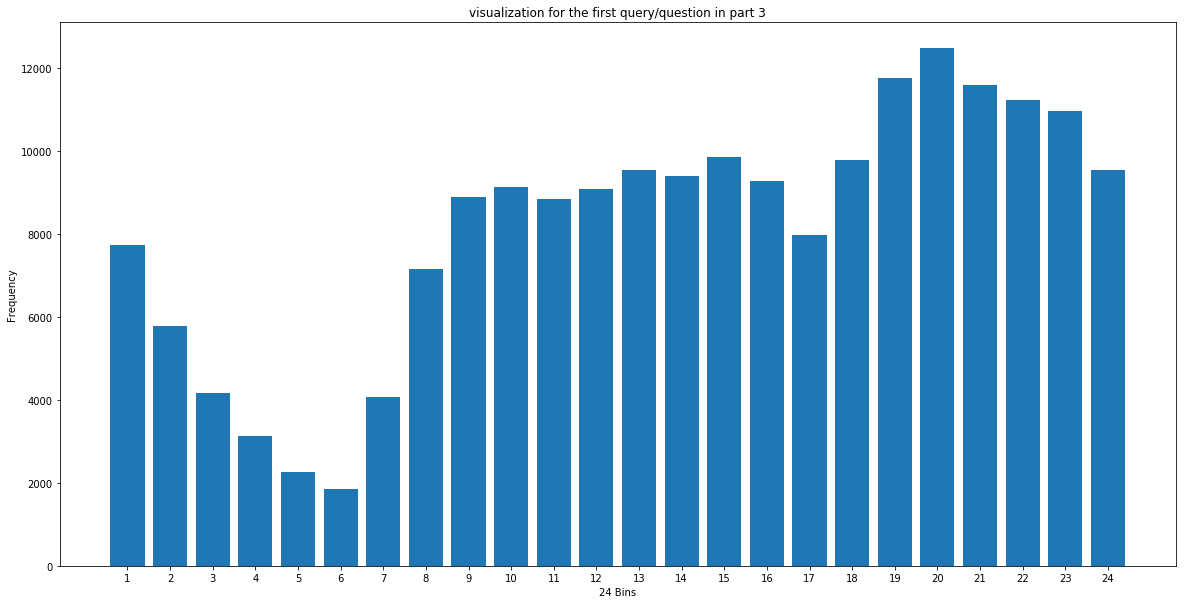

In [62]:
plot_first_question_part3(taxi_data)

# The graph shows that the most popular hour is the 20th hour interval which is the time 19:00 to 20:00.

### Question 2

In [55]:
def plot_90_CI_around_mean(dataframe_1,dataframe_2):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    mean_each_month = []
    for i in range(12):
        taxi_mean = dataframe_1["Distance"][dataframe_1["Month"] == i+1].mean()
        uber_mean = dataframe_2["Distance"][dataframe_2["Month"] == i+1].mean()
        mean = (taxi_mean + uber_mean)/2
        mean_each_month.append(mean)
    
    # Create the data set
    x = np.arange(1, 13, 1)
    y = mean_each_month
                              
    # Define the 90% confidence interval
    ci = 1.645 * np.std(y)/ np.sqrt(len(x))
                              
    # Plot the mean
    plt.plot(x, y)
                              
    # Plot the confidence interval
    plt.fill_between(x, (y-ci), (y+ci), color='blue', alpha=0.1)
    
    plt.xlabel('Each Month')
    plt.ylabel('Average and CI')
    plt.title("90% confidence interval around the mean")
    
    plt.xticks(x)
    plt.show()

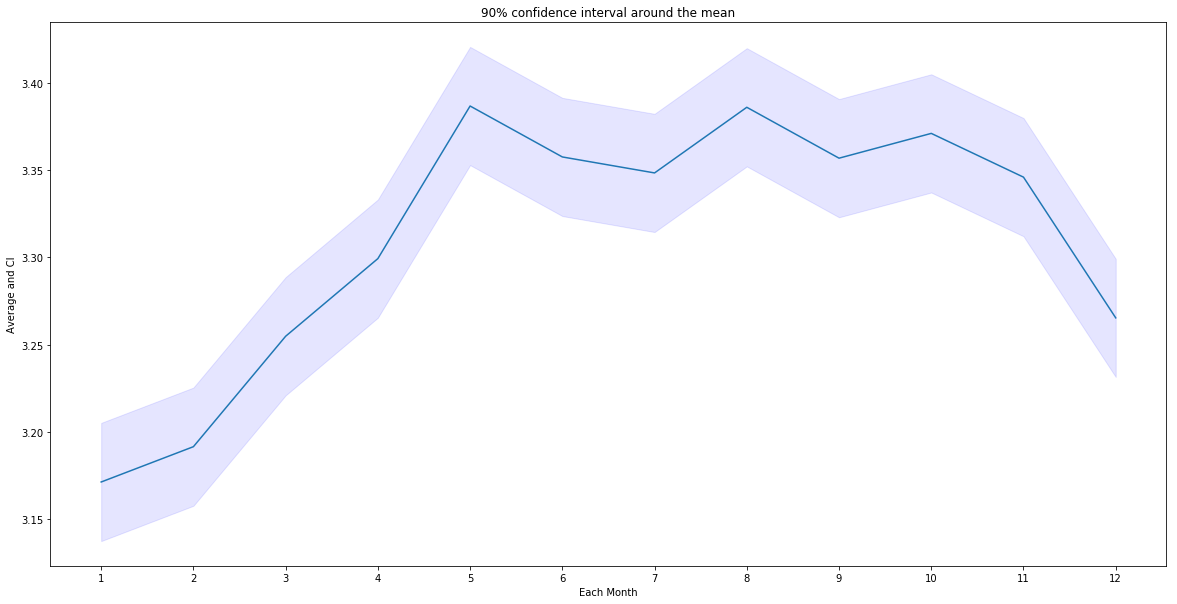

In [56]:
plot_90_CI_around_mean(taxi_data,uber_data)

### Question 3

In [57]:
def airport_popular_day(data_1,data_2):
    
    JFK_BOX_COORDS = ((40.626284,-73.825355),(40.666140,-73.746047))
    LGA_BOX_COORDS = ((40.766849,-73.890242),(40.785373,-73.855566))
    EWR_BOX_COORDS = ((40.670489,-74.193351),(40.708106,-74.153182))
    
    figure, axes = plt.subplots(figsize=(20, 10))
    
    taxi_data_JFK_1 = data_1[data_1["Dropoff_Longitude"] <= JFK_BOX_COORDS[1][1]]
    taxi_data_JFK_2 = taxi_data_JFK_1[taxi_data_JFK_1["Dropoff_Longitude"] >= JFK_BOX_COORDS[0][1]]
    taxi_data_JFK_3 = taxi_data_JFK_2[taxi_data_JFK_2["Dropoff_Latitude"] <= JFK_BOX_COORDS[1][0]]
    taxi_data_JFK = taxi_data_JFK_3[taxi_data_JFK_3["Dropoff_Latitude"] >= JFK_BOX_COORDS[0][0]]
    
    taxi_data_LGA_1 = data_1[data_1["Dropoff_Longitude"] <= LGA_BOX_COORDS[1][1]]
    taxi_data_LGA_2 = taxi_data_LGA_1[taxi_data_LGA_1["Dropoff_Longitude"] >= LGA_BOX_COORDS[0][1]]
    taxi_data_LGA_3 = taxi_data_LGA_2[taxi_data_LGA_2["Dropoff_Latitude"] <= LGA_BOX_COORDS[1][0]]
    taxi_data_LGA = taxi_data_LGA_3[taxi_data_LGA_3["Dropoff_Latitude"] >= LGA_BOX_COORDS[0][0]]
    
    taxi_data_EWR_1 = data_1[data_1["Dropoff_Longitude"] <= EWR_BOX_COORDS[1][1]]
    taxi_data_EWR_2 = taxi_data_EWR_1[taxi_data_EWR_1["Dropoff_Longitude"] >= EWR_BOX_COORDS[0][1]]
    taxi_data_EWR_3 = taxi_data_EWR_2[taxi_data_EWR_2["Dropoff_Latitude"] <= EWR_BOX_COORDS[1][0]]
    taxi_data_EWR = taxi_data_EWR_3[taxi_data_EWR_3["Dropoff_Latitude"] >= EWR_BOX_COORDS[0][0]]
    
    uber_data_JFK_1 = data_2[data_2["Dropoff_Longitude"] <= JFK_BOX_COORDS[1][1]]
    uber_data_JFK_2 = uber_data_JFK_1[uber_data_JFK_1["Dropoff_Longitude"] >= JFK_BOX_COORDS[0][1]]
    uber_data_JFK_3 = uber_data_JFK_2[uber_data_JFK_2["Dropoff_Latitude"] <= JFK_BOX_COORDS[1][0]]
    uber_data_JFK = uber_data_JFK_3[uber_data_JFK_3["Dropoff_Latitude"] >= JFK_BOX_COORDS[0][0]]
    
    uber_data_LGA_1 = data_2[data_2["Dropoff_Longitude"] <= LGA_BOX_COORDS[1][1]]
    uber_data_LGA_2 = uber_data_LGA_1[uber_data_LGA_1["Dropoff_Longitude"] >= LGA_BOX_COORDS[0][1]]
    uber_data_LGA_3 = uber_data_LGA_2[uber_data_LGA_2["Dropoff_Latitude"] <= LGA_BOX_COORDS[1][0]]
    uber_data_LGA = uber_data_LGA_3[uber_data_LGA_3["Dropoff_Latitude"] >= LGA_BOX_COORDS[0][0]]
    
    uber_data_EWR_1 = data_2[data_2["Dropoff_Longitude"] <= EWR_BOX_COORDS[1][1]]
    uber_data_EWR_2 = uber_data_EWR_1[uber_data_EWR_1["Dropoff_Longitude"] >= EWR_BOX_COORDS[0][1]]
    uber_data_EWR_3 = uber_data_EWR_2[uber_data_EWR_2["Dropoff_Latitude"] <= EWR_BOX_COORDS[1][0]]
    uber_data_EWR = uber_data_EWR_3[uber_data_EWR_3["Dropoff_Latitude"] >= EWR_BOX_COORDS[0][0]]
    
    # Count most popular day of week
    
    JFK_taxi = taxi_data_JFK["DayofWeek"].groupby(taxi_data_JFK["DayofWeek"]).count()
    JFK_uber = uber_data_JFK["DayofWeek"].groupby(uber_data_JFK["DayofWeek"]).count()
    
    Monday = JFK_taxi["Monday"] + JFK_uber["Monday"]
    Tuesday = JFK_taxi["Tuesday"] + JFK_uber["Tuesday"]
    Wednesday = JFK_taxi["Wednesday"] + JFK_uber["Wednesday"]
    Thursday = JFK_taxi["Thursday"] + JFK_uber["Thursday"]
    Friday = JFK_taxi["Friday"] + JFK_uber["Friday"]
    Saturday = JFK_taxi["Saturday"] + JFK_uber["Saturday"]
    Sunday = JFK_taxi["Sunday"] + JFK_uber["Sunday"]
    
    JFK = [Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday]
    
    LGA_taxi = taxi_data_LGA["DayofWeek"].groupby(taxi_data_LGA["DayofWeek"]).count()
    LGA_uber = uber_data_LGA["DayofWeek"].groupby(uber_data_LGA["DayofWeek"]).count()
    
    Monday = LGA_taxi["Monday"] + LGA_uber["Monday"]
    Tuesday = LGA_taxi["Tuesday"] + LGA_uber["Tuesday"]
    Wednesday = LGA_taxi["Wednesday"] + LGA_uber["Wednesday"]
    Thursday = LGA_taxi["Thursday"] + LGA_uber["Thursday"]
    Friday = LGA_taxi["Friday"] + LGA_uber["Friday"]
    Saturday = LGA_taxi["Saturday"] + LGA_uber["Saturday"]
    Sunday = LGA_taxi["Sunday"] + LGA_uber["Sunday"]
    
    LGA = [Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday]
    
    EWR_taxi = taxi_data_EWR["DayofWeek"].groupby(taxi_data_EWR["DayofWeek"]).count()
    EWR_uber = uber_data_EWR["DayofWeek"].groupby(uber_data_EWR["DayofWeek"]).count()
    
    Monday = EWR_taxi["Monday"] + EWR_uber["Monday"]
    Tuesday = EWR_taxi["Tuesday"] + EWR_uber["Tuesday"]
    Wednesday = EWR_taxi["Wednesday"] + EWR_uber["Wednesday"]
    Thursday = EWR_taxi["Thursday"] + EWR_uber["Thursday"]
    Friday = EWR_taxi["Friday"] + EWR_uber["Friday"]
    Saturday = EWR_taxi["Saturday"] + EWR_uber["Saturday"]
    Sunday = EWR_taxi["Sunday"] + EWR_uber["Sunday"]
    
    EWR = [Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday] 
    
    #print(JFK,LGA,EWR)
                              
    # Plot JFK
    
    x = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    
    plt.bar(x, JFK, color='yellow', alpha = 0.5)
    
    plt.bar(x, LGA, color='blue',alpha = 0.1)
    
    plt.bar(x, EWR, color='green')

    plt.xlabel('Day of Week')
    plt.ylabel('DROP OFF TIME')
    plt.title("day of the week was most popular for drop offs for each airport")
    
    plt.xticks(x)
    plt.show()

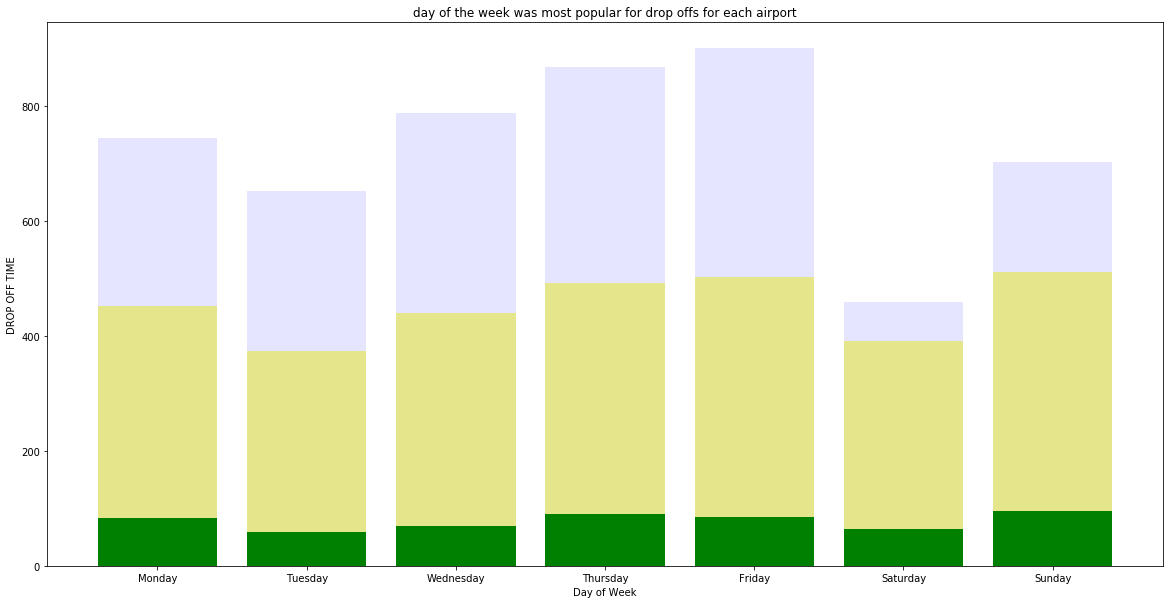

In [58]:
airport_popular_day(taxi_data,uber_data)

# according to the graph, we can see that blue bar is for LGA, and its most popular day is Friday
# yellow bar is for JFK, and its most popular day is Sunday
# green bar is for EWR, and its most popular day is Sunday

### Question 4

In [ ]:
!pip install keplergl

In [ ]:
from keplergl import KeplerGl

In [ ]:
def heatmap(data):

    base = taxi_data
    get_map = KeplerGl(height = 300)
    get_map.add_data(data = base, name = "heatmap of all hired trips over a map of the area")
    get_map

In [ ]:
heatmap(taxi_data)

### Question 5

In [64]:
def compare_tip_distacne(data):
    
    figure, axes = plt.subplots(figsize=(20, 10))
    
    
    # Remove too large tip amount b/c most of them are less than 25
    
    x = data["Distance"][data["Tip_Amount"] <= 25]
    y = data["Tip_Amount"][data["Tip_Amount"] <= 25]
    
    plt.scatter(x,y)
    
    plt.xlabel('Distance')
    plt.ylabel('Tip_Amount')
    plt.title("tip amount versus distance")
    
    plt.show()

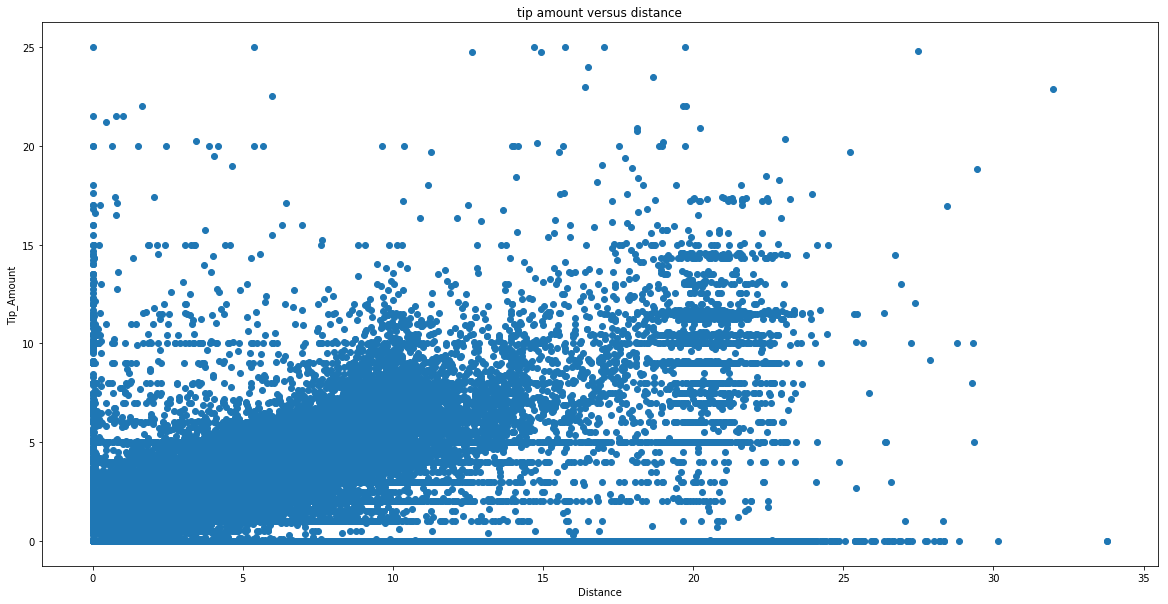

In [65]:
compare_tip_distacne(taxi_data)

### Question 6

### Question 7

#### P1: what hour of the day of week was the most popular to take a Yellow Taxi? The result should have 24 bins